# Practicality Check

The purpose of this notebook is to check whether the idea of trading off safety for efficiency by constraining the policy ratio can give useful results while maintaining reasonable bounds on safety.

In [84]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from abc import ABC, abstractmethod

# Set problem dimensions
STATE_DIM: int = 3
ACT_DIM: int = 2

In [85]:
# Set up CVXPY program
class ProjectionSolver():
        
    def __init__(self,
                 cp_beta: float = 1.0,
                 ) -> None:

        # Initialise variables and parameters (use cp prefix to avoid conflicts elsewhere)
        self.cp_eta = 1e-8 # used to enforce strict inequality

        self.cp_beta = cp.Parameter() # (> 1) constraint on maximum policy ratio

        assert cp_beta >= 1.0, "cp_beta must be >= 1.0"

        self.cp_beta.value = cp_beta

        # base policy (cvxpy parameters)
        self.cp_mu_base = cp.Parameter(ACT_DIM)
        self.cp_sig_base = cp.Parameter(ACT_DIM, pos=True)

        # task policy (cvxpy parameters)
        self.cp_mu_task = cp.Parameter(ACT_DIM)
        self.cp_sig_task = cp.Parameter(ACT_DIM, pos=True)

        # projected policy (cvxpy variables)
        self.cp_mu_proj = cp.Variable(ACT_DIM)
        self.cp_sig_proj = cp.Variable(ACT_DIM, pos=True)


        # Additional variables/parameters for DPP
        # base policy (cvxpy parameters)
        self.cp_sig_base_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sig_base
        self.cp_sig_sig_base = cp.Parameter(ACT_DIM, pos=True) # sig_base^2

        # task policy (cvxpy parameters)
        self.cp_sig_task_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sig_task
        self.cp_mu_sig_task = cp.Parameter(ACT_DIM) # mu_task/sig_task
        self.cp_mu_sig_sig_task = cp.Parameter(ACT_DIM)   # mu_task/(sig_task)^2

        # sum term (cvxpy variables)
        self.cp_mu_base_var = cp.Variable(ACT_DIM)   # mu_base
        self.cp_sig_sig_base_var = cp.Variable(ACT_DIM, pos=True)   # sig_base^2

        # Problem definition (as DPP)
        objective = (cp.Minimize(-2*cp.sum(cp.log(self.cp_sig_proj))
                                + cp.sum_squares(cp.multiply(self.cp_sig_proj,self.cp_sig_task_inv))
                                + cp.sum_squares(cp.multiply(self.cp_mu_proj,self.cp_sig_task_inv))
                                - 2*cp.sum(cp.multiply(self.cp_mu_proj, self.cp_mu_sig_sig_task))
                                + cp.sum_squares(self.cp_mu_sig_task)))

        constraints = []

        constraint_1 = self.cp_sig_proj + self.cp_eta <= self.cp_sig_base
        constraints.append(constraint_1)

        # we define the sum term like this so that we can use quad_over_lin and thus allow the
        # problem to be DCP (standard quotient operator is not DCP)
        # note that numerator gets squared (which we want)
        sum_term = 0
        for i in range(0, ACT_DIM):
            sum_term += cp.quad_over_lin(self.cp_mu_proj[i]-self.cp_mu_base_var[i],
                                         self.cp_sig_sig_base_var[i]-cp.square(self.cp_sig_proj[i]))

        constraint_2 = (-cp.sum(cp.log(self.cp_sig_base_inv))
                        - cp.sum(cp.log(self.cp_sig_proj))
                        + (1/2)*sum_term <= cp.log(self.cp_beta))
        constraints.append(constraint_2)

        constraint_3 = self.cp_mu_base_var == self.cp_mu_base
        constraints.append(constraint_3)

        constraint_4 = self.cp_sig_sig_base_var == self.cp_sig_sig_base
        constraints.append(constraint_4)

        self.cp_prob = cp.Problem(objective, constraints)

    def set_cp_beta(self, cp_beta:float) -> None:
        assert cp_beta >= 1.0, "cp_beta must be >= 1.0"
        self.cp_beta.value = cp_beta

    def get_proj_mean_std(self,
                          mean_base: np.ndarray,
                          std_base: np.ndarray,
                          mean_task: np.ndarray,
                          std_task: np.ndarray,
                          ) -> tuple[np.ndarray, np.ndarray]:

        # If beta set to 1 (or incorrectly < 1), just roll out the base policy
        if self.cp_beta.value <= 1.0:
            mean_proj = mean_base
            std_proj = std_base

        # Otherwise compute the projected policy
        else:
            # Set projection problem parameters
            self.cp_mu_base.value = mean_base
            self.cp_sig_base.value = std_base

            self.cp_mu_task.value = mean_task
            self.cp_sig_task.value = std_task

            self.cp_sig_base_inv.value = 1/std_base
            self.cp_sig_sig_base.value = np.square(std_base)

            self.cp_sig_task_inv.value = 1/std_task
            self.cp_mu_sig_task.value = mean_task/std_task
            self.cp_mu_sig_sig_task.value = mean_task/np.square(std_task)

            # Project into feasible set
            result = self.cp_prob.solve()

            # Extract projected mean and std
            mean_proj = self.cp_mu_proj.value
            std_proj = self.cp_sig_proj.value

        return mean_proj, std_proj

In [125]:
# Define environment
class Env():

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 dt: float = 1.0,
                 env_noise_std: np.ndarray = 1e-4*np.ones(ACT_DIM),
                 env_start_mean: np.ndarray = np.zeros(STATE_DIM),
                 env_start_std: np.ndarray = np.ones(STATE_DIM),
                 ) -> None:
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.dt = dt
        self.env_noise_std = env_noise_std
        self.env_start_mean = env_start_mean
        self.env_start_std = env_start_std

    def reset(self,
              norm_init_state: np.ndarray,
              ) -> np.ndarray:
        init_state = self.env_start_mean + norm_init_state * self.env_start_std
        return init_state
    
    def is_in_goal(self,
                   state: np.ndarray,
                   ) -> bool:
        if np.linalg.norm(self.goal_pos - state[0:2]) <= self.goal_r:
            return True
        else:
            return False
        
    def is_in_haz(self,
                  state: np.ndarray,
                  ) -> bool:
        if np.linalg.norm(self.haz_pos - state[0:2]) <= self.haz_r:
            return True
        else:
            return False

    def step(self,
             state: np.ndarray,
             norm_action: np.ndarray,
             act_mean: np.ndarray,
             act_std: np.ndarray,
             norm_noise: np.ndarray,
             ) -> tuple[np.ndarray, bool, bool]:
        next_state = np.empty(shape=(STATE_DIM))
        v = act_mean[0] + norm_action[0] * act_std[0] + norm_noise[0] * self.env_noise_std[0]
        omega = act_mean[1] + norm_action[1] * act_std[1] + norm_noise[1] * self.env_noise_std[1]
        next_state[0] = state[0] + self.dt * v * np.cos(state[2] + self.dt * omega)
        next_state[1] = state[1] + self.dt * v * np.sin(state[2] + self.dt * omega)
        next_state[2] = state[2] + self.dt * omega

        return next_state, self.is_in_goal(next_state), self.is_in_haz(next_state)

In [146]:
class Policy(ABC):

    @abstractmethod
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> np.ndarray:
        pass

# Define base policy
class BasePolicy(Policy):

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 avoidance_r: float,
                 policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 avoidance_factor: float = 10.0,
                 ) -> None:
        super().__init__()
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.avoidance_r = avoidance_r
        self.policy_std = policy_std
        self.max_step_size = max_step_size
        self.avoidance_factor = avoidance_factor
    
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> tuple[np.ndarray, np.ndarray]:
        vec_to_goal = self.goal_pos - state[0:2]

        vec_from_haz = state[0:2] - self.haz_pos

        vec_combined = (vec_to_goal
                        + vec_from_haz * max(0,min(1/self.haz_r, 1/np.linalg.norm(vec_from_haz)) - 1/(self.haz_r + self.avoidance_r))
                        * 1/(1/self.haz_r - 1/(self.haz_r + self.avoidance_r)) * self.avoidance_factor)

        vel = np.linalg.norm(vec_combined)
        omg = np.arctan2(vec_combined[1],vec_combined[0]) - state[2]
        
        action = np.zeros(ACT_DIM)
        action[0] = max(-self.max_step_size[0],min(vel, self.max_step_size[0]))
        action[1] = max(-self.max_step_size[1],min(omg, self.max_step_size[1]))
        
        return action, self.policy_std

# Define task policy
class TaskPolicy(Policy):

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 ) -> None:
        super().__init__()
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.policy_std = policy_std
        self.max_step_size = max_step_size
    
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> tuple[np.ndarray, np.ndarray]:
        vec_to_goal = self.goal_pos - state[0:2]

        vel = np.linalg.norm(vec_to_goal)
        omg = np.arctan2(vec_to_goal[1],vec_to_goal[0]) - state[2]
        
        action = np.zeros(ACT_DIM)
        action[0] = max(-self.max_step_size[0],min(vel, self.max_step_size[0]))
        action[1] = max(-self.max_step_size[1],min(omg, self.max_step_size[1]))
        
        return action, self.policy_std


In [147]:
class TrajectoryGenerator():

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 avoidance_r: float,
                 base_policy_std: np.ndarray,
                 task_policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 avoidance_factor: float = 10.0,
                 dt: float = 1.0,
                 env_noise_std: np.ndarray = 1e-4*np.ones(ACT_DIM),
                 env_start_mean: np.ndarray = np.zeros(STATE_DIM),
                 env_start_std: np.ndarray = np.ones(STATE_DIM),
                 cp_beta: float = 1.0,
                ) -> None:
        
        self.env = Env(goal_pos=goal_pos,
                       goal_r=goal_r,
                       haz_pos=haz_pos,
                       haz_r=haz_r,
                       dt=dt,
                       env_noise_std=env_noise_std,
                       env_start_mean=env_start_mean,
                       env_start_std=env_start_std,
                       )
        self.base_policy = BasePolicy(goal_pos=goal_pos,
                                      goal_r=goal_r,
                                      haz_pos=haz_pos,
                                      haz_r=haz_r,
                                      avoidance_r=avoidance_r,
                                      policy_std=base_policy_std,
                                      max_step_size=max_step_size,
                                      avoidance_factor=avoidance_factor,
                                      )
        self.task_policy = TaskPolicy(goal_pos=goal_pos,
                                      goal_r=goal_r,
                                      haz_pos=haz_pos,
                                      haz_r=haz_r,
                                      policy_std=task_policy_std,
                                      max_step_size=max_step_size,
                                      )
        self.proj_solver = ProjectionSolver(cp_beta=cp_beta)

    def set_cp_beta(self,
                    cp_beta: float,
                    ) -> None:
        self.proj_solver.set_cp_beta(cp_beta)

    def set_goal_pos(self,
                     goal_pos: np.ndarray,
                     ) -> None:
        self.env.goal_pos = goal_pos
        self.base_policy.goal_pos = goal_pos
        self.task_policy.goal_pos = goal_pos

    def generate_trajectories(self,
                              num: int,
                              length:int,
                              mode:str = 'default',
                              seed:int = 0,
                              ) -> tuple[np.ndarray, list, list, list]:
        traj_array = np.empty(shape=(num, length+1, STATE_DIM))
        entered_hazard_list = []
        reached_goal_list = []
        time_to_goal_list = []
        rng = np.random.default_rng(seed)
        for i in range(0, num):
            entered_hazard = False
            reached_goal = False
            state = self.env.reset(rng.normal(size=STATE_DIM))
            traj_array[i][0][:] = state
            for t in range(1,length+1):
                
                mean_base, std_base = self.base_policy.get_mean_std(state)
                mean_task, std_task = self.task_policy.get_mean_std(state)

                if mode == 'base':
                    act_mean, act_std = mean_base, std_base
                elif mode == 'task':
                    act_mean, act_std = mean_task, std_task
                else:
                    act_mean, act_std = self.proj_solver.get_proj_mean_std(mean_base, std_base, mean_task, std_task)
                state, goal, haz = self.env.step(state, rng.normal(size=ACT_DIM), act_mean, act_std, rng.normal(size=ACT_DIM))
                traj_array[i][t][:] = state
                if goal and reached_goal == False:
                    reached_goal_list.append(True)
                    time_to_goal_list.append(t)
                    reached_goal = True
                if haz and entered_hazard == False:
                    entered_hazard_list.append(True)
                    entered_hazard = True

            if reached_goal == False:
                reached_goal_list.append(False)
                time_to_goal_list.append(np.nan)

            if entered_hazard == False:
                entered_hazard_list.append(False)

        return traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list

In [250]:
START_X = 0.0
START_Y = 0.0
START_R = 3.0

GOAL_X = 80.0
GOAL_Y = 0.0
GOAL_R = 10.0

HAZ_X = 40.0
HAZ_Y = -5.0
HAZ_R = 10.0

DT = 1.0

In [249]:
# Create dict to hold trajectories
traj_dict = {}

In [262]:
# Instantiate trajectory generator
traj_generator=TrajectoryGenerator(goal_pos=np.array([GOAL_X,GOAL_Y]),
                                   goal_r=GOAL_R,
                                   haz_pos=np.array([HAZ_X,HAZ_Y]),
                                   haz_r=HAZ_R,
                                   avoidance_r=30.0,
                                   base_policy_std=np.array([8e-1,8e-1]),
                                   task_policy_std=np.array([1e-2,1e-2]),
                                   max_step_size=np.array([2e0,3e0]),
                                   avoidance_factor=15.0,
                                   dt=DT,
                                   env_noise_std=np.array([1e-3,1e-3]),
                                   env_start_mean=np.array([START_X,START_Y,0.0]),
                                   env_start_std=np.array([START_R/3,START_R/3,1e0]),
                                   cp_beta=1.01,
                                   )

In [263]:
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='base',
                                                                                                             seed=0)
traj_dict['base'] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'blue']

In [264]:
cp_beta = 1.1
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'grey']

/home/jacques/miniconda3/envs/rl-safety-filters/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [265]:
cp_beta = 1.5
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'pink']

In [266]:
cp_beta = 2.0
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'yellow']

In [267]:
cp_beta = 5.0
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'green']

In [268]:
cp_beta = 10.0
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'cyan']

In [269]:
cp_beta = 20.0
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'purple']

In [273]:
cp_beta = 30.0
traj_generator.set_cp_beta(cp_beta)
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='default',
                                                                                                             seed=0)
traj_dict[cp_beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'orangered']

In [271]:
traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=10,
                                                                                                             length=100,
                                                                                                             mode='task',
                                                                                                             seed=0)
traj_dict['task'] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, 'orange']

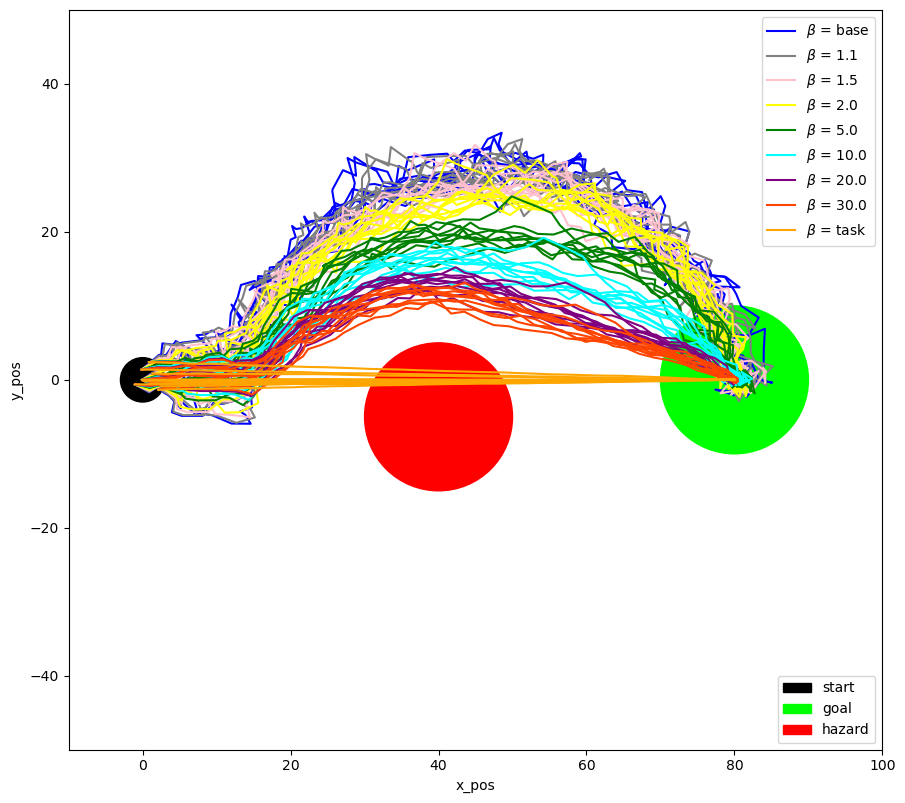

β         avg. time to goal   hazard hit rate     goal reach rate     
base      72.8                0.0                 100.0               
1.1       68.8                0.0                 100.0               
1.5       60.1                0.0                 100.0               
2.0       56.2                0.0                 100.0               
5.0       47.5                0.0                 100.0               
10.0      43.0                0.0                 100.0               
20.0      40.1                0.0                 100.0               
30.0      39.1                0.0                 100.0               
task      35.1                100.0               100.0               


In [279]:
start = plt.Circle((START_X,START_Y), START_R, color='black', label='start')
goal = plt.Circle((GOAL_X,GOAL_Y), GOAL_R, color='lime', label='goal')
haz = plt.Circle((HAZ_X,HAZ_Y), HAZ_R, color='r', label='hazard')

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)

ax.add_patch(start)
ax.add_patch(goal)
ax.add_patch(haz)
patch_legend = ax.legend(handles=[start,goal,haz], loc='lower right')
ax.add_artist(patch_legend)

l = []

for key in traj_dict.keys():
    for i in range(0,traj_dict[key][0].shape[0]):
        plt.plot(traj_dict[key][0][i,:,0],traj_dict[key][0][i,:,1], color=traj_dict[key][4])
    l.append(mlines.Line2D([],[], color=traj_dict[key][4], label=r'$\beta$ = '+str(key)))


ax.set_xlim(-10,100)
ax.set_xlabel('x_pos')
ax.set_ylim(-50,50)
ax.set_ylabel('y_pos')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

ax.legend(handles=l, loc='upper right')
plt.show()
beta_str = "\u03B2"
print(f'{beta_str:<10}{"avg. time to goal":<20}'
      f'{"hazard hit rate":<20}'
      f'{"goal reach rate":<20}')
for key in traj_dict.keys():
    print(f'{str(key):<10}'
          f'{f"{np.nanmean(traj_dict[key][3]):.1f}":<20}'
          f'{f"{np.mean(traj_dict[key][1])*100:.1f}":<20}'
          f'{f"{np.mean(traj_dict[key][2])*100:.1f}":<20}')